## Lunar Lander Agent

#### Dependencies

In [ ]:
!pip install swig
!pip install gymnasium[box2d]

  Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.9 MB)


#### Introduction

All of this information is from [Gymnasium documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

###### Description

This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

###### Action space

There are four discrete actions available:

0: do nothing

1: fire left orientation engine

2: fire main engine

3: fire right orientation engine

##### Observation Space

The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

##### Rewards

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

##### Starting State

The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

##### Episode Termination

The episode finishes if:

- the lander crashes (the lander body gets in contact with the moon);

- the lander gets outside of the viewport (x coordinate is greater than 1);

- the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:



> When Box2D determines that a body (or group of bodies) has come to rest, the body enters a sleep state which has very little CPU overhead. If a body is awake and collides with a sleeping body, then the sleeping body wakes up. Bodies will also wake up if a joint or contact attached to them is destroyed.



#### Visualization of the enviroment

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Crear entorno
env = gym.make("LunarLander-v3", render_mode="rgb_array")
obs, info = env.reset()

# Guardar los frames
frames = []
done = False
while not done:
    frames.append(env.render())
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated

env.close()

# Crear animación sin mostrar imagen fija
fig, ax = plt.subplots()
ax.axis('off')  # Oculta ejes
im = ax.imshow(frames[0], animated=True)

def animate(i):
    im.set_array(frames[i])
    return [im]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
plt.close(fig)
HTML(ani.to_jshtml())

#### Theory

**What is Q learning?**

Q-Learning is a reinforcement learning algorithm that teaches an agent to make decisions to get the highest possible reward over time.

Imagine you are in a maze and your goal is to reach the exit. Every time you make a move, you receive a reward (positive if you make good progress, negative if you hit a wall). At the beginning you don't know anything, but with trial and error, you learn what to do in each place.

**The key idea of Q-Learning**

The agent learns a table of values, called **Q-table**, where it stores how good it is to take a certain action in a certain state.

We represent this as Q(s, a) which means:

> “How good is action a if I am in state s?”



**How does it learn?**

Every time the agent does something and receives a reward, it updates the Q-table with this formula:

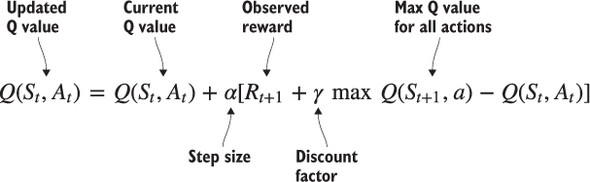

- Q(s, a): What I knew so far.

- r: Reward obtained for the action.

- γ - max Q(s', a'): The best he can get in the future.

- α: How much he trusts the new vs. the old.

The agent adjusts his knowledge based on what happened and what he thinks may happen if he continues to learn.

**An example**

Imagine you are on a 4x4 grid and you can move up, down, left or right.

- State = your current position.

- Action = where you are moving to.

- Reward = +1 if you reach the goal, 0 otherwise.

With Q-learning, you explore, noting in a table how good each direction is from each square. Then you choose the best ones.

**Important**

- State: where you are.

- Action: what you decide to do.

- Reward: what you get for doing that.

- Q-table: table that you learn with values of how good your decisions are.

###### **Q-table vs Q-network (the move from Q-learning to DQN)**

**📦 Q-table: the classic one**
In traditional Q-learning, we use a table (matrix) to store the Q(s, a) values.

**✅ Advantages:**

- Easy to implement.

- Works well when there are few states and actions.

**❌ Problems:**

- If the number of states or actions grows very large (e.g., in a video game or if the states are images), the table becomes huge or infinite.

- Cannot generalize: if you see a new state that looks like an old one, you don't know what to do.

**🧠 Q-network: the modern thing.**

When the Q-table is no longer sufficient, we use a neural network to approximate the Q(s, a) function. **This is called Deep Q-Learning or DQN.**

The network takes the state as input and returns Q-values for each possible action.
It is trained to learn to estimate *“how good an action is from a state”*.

🎮 Simple example:
Imagine you are training an AI to play a game like Pong or CartPole.

State = position of the ball and paddles.

Action = move paddle left, right or stand still.

**Instead of keeping a huge table for each pixel combination, you train a network that learns to tell you the value of each action.**

**🔁 Clear difference**

|                       | Q-table                     | Q-network                     |
|-----------------------|-----------------------------|-------------------------------|
| 🧠 Forma de aprender  | Guarda valores en una tabla | Usa red neuronal              |
| 🧮 Escalabilidad      | No escala bien               | Escala a problemas complejos  |
| 📷 Entrada compleja   | Solo estados simples         | Puede usar imágenes o vectores|
| 🧠 Generalización     | No generaliza                | Generaliza a estados parecidos|

##### **🧪 ¿Qué es Experience Replay?**

Cuando un agente aprende, lo hace interactuando con el entorno paso a paso. Por ejemplo:

1. Está en un estado s

2. Toma una acción a

3. Recibe una recompensa r

4. Llega a un nuevo estado s'

Esto forma una "experiencia":



```
(s, a, r, s')
```

**❗ Problema sin replay:**

En el mundo real, las experiencias llegan en orden secuencial. Si entrenas la red directamente con las experiencias recientes, el aprendizaje puede ser inestable o sesgado, porque:

- Las muestras están muy correlacionadas (todas vienen de la misma parte del juego).

- No se reutiliza información útil del pasado.

- Se sobreajustan los pasos más recientes y se olvidan los importantes.


**✅ Solución: Replay Buffer**

El agente guarda muchas de esas experiencias en una memoria (como una lista), llamada replay buffer.
Después, elige al azar algunas experiencias antiguas y las usa para entrenar.

**🔁 ¿Por qué esto ayuda?**
- Rompe la dependencia temporal entre datos (menos ruido).

- Reutiliza experiencias pasadas.

- Hace que el entrenamiento de la red sea más estable y eficiente.

**🎒 Ejemplo simple**

Imagina que estás entrenando a una IA para jugar ajedrez. Cada jugada es una experiencia.

Con replay:

- Guardas cada jugada en una libreta.

- Cuando vas a entrenar, abres la libreta y sacas jugadas al azar (algunas del principio, otras del medio, otras recientes).

- Esto evita que aprenda solo de lo último que vio, y permite revisar errores pasados para aprender mejor.

|                         | Sin Replay             | Con Experience Replay        |
|-------------------------|------------------------|------------------------------|
| 📈 Estabilidad           | Baja                   | Mucho más alta               |
| 🔄 Uso de datos          | Solo los recientes     | Reutiliza muchos anteriores  |
| 🧠 Generalización        | Difícil                | Mejora progresiva            |

###### **🎯 ¿Qué es un Target Network?**

En DQN, entrenamos una red neuronal para aprender la función Q(s, a) y tomar buenas decisiones.

Pero hay un problema importante:
Cuando usamos la misma red para predecir el valor actual y el valor futuro… el entrenamiento se vuelve inestable 😵‍💫.

**❗ El problema**

La red se entrena usando esta fórmula (simplificada):

```
Objetivo= r+γ⋅ a ′max Q(s ′,a ′)
```
Ese `Q(s', a')` es el valor estimado del siguiente estado.
Si usamos la misma red que estamos actualizando en cada paso para calcular ese valor… el objetivo va cambiando constantemente mientras lo persigues → esto puede hacer que nunca converja.

Es como intentar caminar hacia un objetivo que se mueve con cada paso que das.


**✅ La solución: usar dos redes**

**1. Online Network:**

- Es la red principal, que se está entrenando todo el tiempo.

- Aprende a tomar mejores decisiones.

**2. Target Network:**

- Es una copia congelada de la online.

- Se usa para calcular el valor del siguiente estado Q(s', a').

- Se actualiza lentamente, cada cierto número de pasos (por ejemplo, cada 1000 pasos copiamos los pesos de la online).

**🧠 ¿Qué ganamos con esto?**

- La Target Network se mantiene estable, por lo que el objetivo de aprendizaje no cambia tanto.

- Esto hace que el entrenamiento sea más confiable y suave.

**🎯 Ejemplo simple**
Imagina que estás aprendiendo a lanzar una flecha a un blanco.

- Si el blanco se mueve cada vez que corriges tu puntería, ¡es casi imposible acertar!

- Pero si lo congelas durante varios lanzamientos, puedes mejorar mucho tu tiro.

Eso es exactamente lo que hace la Target Network en DQN.

|                        | Sin Target Network       | Con Target Network           |
|------------------------|--------------------------|------------------------------|
| 🎯 Objetivo de aprendizaje | Cambia en cada paso         | Se mantiene estable           |
| 📈 Entrenamiento         | Inestable, puede diverger   | Más estable y confiable       |
| 🧠 Estructura            | Una sola red neuronal       | Dos redes: online + target    |

#### Implementation of DQN with experience replay and target network

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation


# Configuración
env = gym.make("LunarLander-v3", render_mode="rgb_array")
# Creamos el entorno LunarLander-v3, que simula una nave aterrizando en la Luna

state_dim = env.observation_space.shape[0]
# Extraemos la dimensión del espacio de observación (estado).
# Esto es necesario para saber cuántas entradas tiene la red.

n_actions = env.action_space.n
# Obtenemos cuántas acciones posibles puede tomar el agente.
# Esto define cuántas salidas tendrá la red (un valor Q por cada acción posible).

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Determinamos si se usará GPU o CPU, dependiendo de si CUDA está disponible.
# Esto se usa para acelerar el entrenamiento si tienes una GPU compatible.

In [ ]:
# Definimos la red neuronal que estimará la Q-function
class DQN(nn.Module):  # Hereda de nn.Module para definir una red neuronal en PyTorch
    def __init__(self):
        super(DQN, self).__init__()  # Inicializa correctamente la clase base nn.Module

        # Definimos una red neuronal totalmente conectada (fully connected)
        self.fc = nn.Sequential(  # Usamos nn.Sequential para encadenar capas de forma sencilla
            nn.Linear(state_dim, 128),  # Primera capa: de dimensión del estado a 128 neuronas
            nn.ReLU(),                  # Función de activación ReLU (introduce no linealidad)
            nn.Linear(128, 128),        # Segunda capa oculta: 128 a 128 neuronas
            nn.ReLU(),                  # Otra ReLU
            nn.Linear(128, n_actions)   # Capa de salida: 128 a número de acciones posibles
            # Esta capa no tiene activación porque queremos los valores Q (pueden ser negativos)
        )

    def forward(self, x):  # Método para definir cómo fluye la información por la red
        return self.fc(x)  # Simplemente pasamos la entrada x por la red definida arriba

**¿Para qué sirve esta red?**

Esta red neuronal DQN se utiliza para aproximar la función Q(s, a), que estima el valor esperado de tomar una acción a en un estado s y seguir la política óptima a partir de ahí. Es el núcleo del algoritmo Deep Q-Learning (DQL).

En resumen:

- Entrada de la red: el estado del entorno.

- Salida de la red: un vector con un valor Q por cada acción posible.

- Durante el entrenamiento, el agente actualizará esta red para aprender a predecir los valores Q más precisos posibles, lo que le permitirá tomar mejores decisiones.

In [ ]:
# Parámetros
#Estos valores controlan el comportamiento de exploración, el aprendizaje del agente, y la estabilidad del entrenamiento.
#Juntos definen cómo el agente mejora su política mediante la experiencia acumulada y las actualizaciones a la red neuronal.


# Parámetro de descuento: cuánto se valora el futuro frente al presente
GAMMA = 0.99
# Un valor cercano a 1 hace que el agente valore mucho las recompensas futuras.

# Tasa de aprendizaje del optimizador
LR = 1e-3
# Define qué tan rápido se actualizan los pesos de la red durante el entrenamiento.

# Valor inicial de epsilon para la estrategia ε-greedy
EPSILON_START = 1.0
# Comenzamos explorando completamente (100% al azar).

# Valor mínimo de epsilon
EPSILON_END = 0.01
# Incluso al final del entrenamiento, dejamos un 1% de probabilidad de tomar acciones al azar,
# para seguir explorando un poco y evitar caer en mínimos locales.

# Parámetro de decaimiento para epsilon
EPSILON_DECAY = 500
# Controla qué tan rápido se reduce epsilon (menos exploración con el tiempo).
# Suele usarse en una fórmula como:
# epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * exp(-step / EPSILON_DECAY)

# Tamaño de lote usado para entrenar con muestras de la memoria de experiencia
BATCH_SIZE = 64
# Cuántas transiciones (estado, acción, recompensa, siguiente estado) se usan por paso de entrenamiento.

# Capacidad máxima de la memoria de experiencia (replay buffer)
MEMORY_SIZE = 100_000
# Guardamos hasta 100 mil experiencias pasadas. Una vez llena, se sobrescriben las más antiguas.

# Frecuencia para actualizar la red objetivo (target network)
TARGET_UPDATE = 10
# Cada 10 episodios, se copian los pesos de la red principal a la red objetivo.
# Esto estabiliza el entrenamiento, evitando cambios bruscos en las predicciones del valor Q.

# Número total de episodios a entrenar
EPISODES = 500
# Entrenaremos el agente durante 500 episodios del entorno.

In [ ]:
# Inicializamos la red principal (policy_net), que se entrenará y tomará decisiones
# La movemos al dispositivo (CPU o GPU) usando `.to(device)`
policy_net = DQN().to(device)

# Inicializamos la red objetivo (target_net), que se usa para calcular los valores objetivos estables
# Esta red no se entrena directamente, sino que se actualiza periódicamente con los pesos de la policy_net
target_net = DQN().to(device)

# Copiamos los pesos actuales de la red principal (policy_net) a la red objetivo (target_net)
# Esto sincroniza ambas redes al inicio del entrenamiento
target_net.load_state_dict(policy_net.state_dict())

# Establecemos la red objetivo en modo evaluación (eval)
# Esto desactiva comportamientos como Dropout o BatchNorm (aunque esta red no los usa),
# y garantiza que la red no acumule gradientes ni se entrene por error
target_net.eval()

DQN(
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
# Creamos el optimizador Adam para actualizar los pesos de la red neuronal
optimizer = optim.Adam(policy_net.parameters(), lr=LR)

**¿Qué hace esta línea?**
- policy_net.parameters(): obtiene todos los parámetros (pesos) de la red neuronal policy_net que queremos entrenar.

- optim.Adam: es un optimizador de PyTorch que implementa el algoritmo Adam, una técnica muy eficiente que combina las ventajas de AdaGrad y RMSProp. Ajusta la tasa de aprendizaje para cada parámetro automáticamente.

- lr=LR: le damos como tasa de aprendizaje el valor que definimos antes (por ejemplo, 1e-3).

Esto significa: cada vez que hagamos backpropagation, el optimizador usará este objeto para aplicar los gradientes y actualizar los pesos de la red.

In [ ]:
# Creamos una memoria de experiencias con una capacidad máxima
memory = deque(maxlen=MEMORY_SIZE)

**¿Qué hace esta línea?**
- deque: es una estructura de datos tipo cola (double-ended queue) que permite agregar y eliminar elementos eficientemente de ambos extremos.

- maxlen=MEMORY_SIZE: limita la cantidad de elementos que puede guardar. Si se alcanza el máximo, se eliminan automáticamente las experiencias más antiguas cuando se añaden nuevas.

**¿Qué se guarda en memory?**

Se guardan tuplas de experiencia en la forma típica:

```
(state, action, reward, next_state, done)
```

Esto forma el replay buffer, una memoria de experiencias pasadas desde la cual se extraen minibatches de ejemplos aleatorios para entrenar al agente, lo que:

- Rompe la correlación temporal entre muestras.

- Mejora la estabilidad del aprendizaje.

In [ ]:
def select_action(state, step):
    # Se calcula epsilon con decaimiento exponencial
    epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * np.exp(-step / EPSILON_DECAY)

    # Con probabilidad epsilon, se elige una acción aleatoria (exploración)
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        # Si no, se elige la mejor acción según la red (explotación)
        # Convertimos el estado a tensor y lo pasamos a la red
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():  # No calculamos gradientes en esta fase
            q_values = policy_net(state)
        return int(torch.argmax(q_values).item())  # Elegimos la acción con el mayor valor Q

Esta función implementa la estrategia ε-greedy, que controla el equilibrio entre:

- **Exploración:** tomar decisiones al azar para descubrir nuevas estrategias.

- **Explotación:** elegir las mejores acciones conocidas hasta ahora.

El valor de epsilon va decayendo con el tiempo (a medida que aumenta step), lo que significa que el agente explorará mucho al principio y cada vez menos conforme aprende.

In [ ]:
def optimize():
    # Si no hay suficientes experiencias almacenadas, no se entrena todavía
    if len(memory) < BATCH_SIZE:
        return

    # Seleccionamos aleatoriamente un lote de experiencias del replay buffer
    batch = random.sample(memory, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    # Convertimos las listas de datos en tensores adecuados para entrenamiento
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)      # .unsqueeze(1) → convierte a shape [BATCH_SIZE, 1]
    rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

    # Obtenemos los valores Q actuales (Q(s, a)) para las acciones tomadas
    current_q = policy_net(states).gather(1, actions)

    # Calculamos los valores Q máximos del siguiente estado según la red objetivo (Q(s', a') con a' óptima)
    max_next_q = target_net(next_states).max(1)[0].detach().unsqueeze(1)

    # Calculamos el valor objetivo de Q usando la ecuación de Bellman: Q_target = r + γ * max_a' Q(s', a') * (1 - done)
    expected_q = rewards + GAMMA * max_next_q * (1 - dones)

    # Calculamos la pérdida entre los valores Q actuales y los esperados (target) usando error cuadrático medio (MSE)
    loss = nn.MSELoss()(current_q, expected_q)

    # Optimizamos: reseteamos los gradientes, hacemos backpropagation y actualizamos los pesos
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Esta función realiza un paso de entrenamiento de la red neuronal, ajustando los pesos de policy_net para minimizar la diferencia entre:

- Lo que la red predice actualmente para Q(s, a)

- Lo que debería predecir según la ecuación de Bellman (valor objetivo)

El uso de la red objetivo (target_net) para calcular max_next_q ayuda a estabilizar el entrenamiento, ya que sus pesos no cambian en cada paso.

**Resumen de lo que hace el siguiente bucle:**

- Ejecuta múltiples episodios del entorno.

- Usa una política basada en ε-greedy para balancear exploración y explotación.

- Acumula experiencia y entrena en cada paso.

- Cada TARGET_UPDATE episodios, sincroniza las redes (policy_net → target_net).

- Guarda recompensas para análisis posterior y muestra resultados periódicamente.

In [ ]:
# Entrenamiento del agente

all_rewards = []         # Lista para guardar la recompensa total por episodio
global_step = 0          # Contador global de pasos (útil para el decaimiento de epsilon)

for episode in range(EPISODES):
    state, _ = env.reset()      # Reiniciamos el entorno y obtenemos el estado inicial
    episode_reward = 0          # Recompensa acumulada en el episodio actual
    done = False                # Variable para controlar el fin del episodio

    while not done:
        # Seleccionamos una acción usando la estrategia ε-greedy
        action = select_action(state, global_step)

        # Ejecutamos la acción en el entorno
        next_state, reward, terminated, truncated, _ = env.step(action)

        # El episodio termina si está terminado o truncado (por límite de pasos, por ejemplo)
        done = terminated or truncated

        # Guardamos la experiencia en el buffer de repetición
        memory.append((state, action, reward, next_state, done))

        # El siguiente estado pasa a ser el estado actual
        state = next_state

        # Acumulamos la recompensa obtenida
        episode_reward += reward

        # Ejecutamos un paso de entrenamiento
        optimize()

        # Avanzamos el contador de pasos globales (para epsilon)
        global_step += 1

    # Guardamos la recompensa total del episodio
    all_rewards.append(episode_reward)

    # Cada cierto número de episodios, actualizamos la red objetivo
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Mostramos progreso cada 10 episodios
    if episode % 10 == 0:
        print(f"Ep {episode}, reward: {episode_reward:.2f}")

# Cerramos el entorno una vez finalizado el entrenamiento
env.close()

<ipython-input-22-012bff7bf698>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states).to(device)


Ep 0, reward: -95.72
Ep 10, reward: -185.83
Ep 20, reward: -230.64
Ep 30, reward: -180.66
Ep 40, reward: -285.33
Ep 50, reward: -193.31
Ep 60, reward: -147.00
Ep 70, reward: -94.87
Ep 80, reward: 46.08
Ep 90, reward: -84.72
Ep 100, reward: -150.60
Ep 110, reward: -109.40
Ep 120, reward: -125.86
Ep 130, reward: -37.85
Ep 140, reward: -149.03
Ep 150, reward: -121.64
Ep 160, reward: -229.36
Ep 170, reward: -144.95
Ep 180, reward: -77.36
Ep 190, reward: -126.64
Ep 200, reward: -81.19
Ep 210, reward: -96.48
Ep 220, reward: 88.26
Ep 230, reward: -71.08
Ep 240, reward: -168.44
Ep 250, reward: -98.34
Ep 260, reward: -76.38
Ep 270, reward: -90.78
Ep 280, reward: -18.53
Ep 290, reward: -86.31
Ep 300, reward: -118.60
Ep 310, reward: 196.75
Ep 320, reward: -40.18
Ep 330, reward: 208.55
Ep 340, reward: -53.03
Ep 350, reward: -69.91
Ep 360, reward: 159.43
Ep 370, reward: 145.90
Ep 380, reward: 171.17
Ep 390, reward: -93.50
Ep 400, reward: 231.19
Ep 410, reward: -131.89
Ep 420, reward: 255.14
Ep 430,

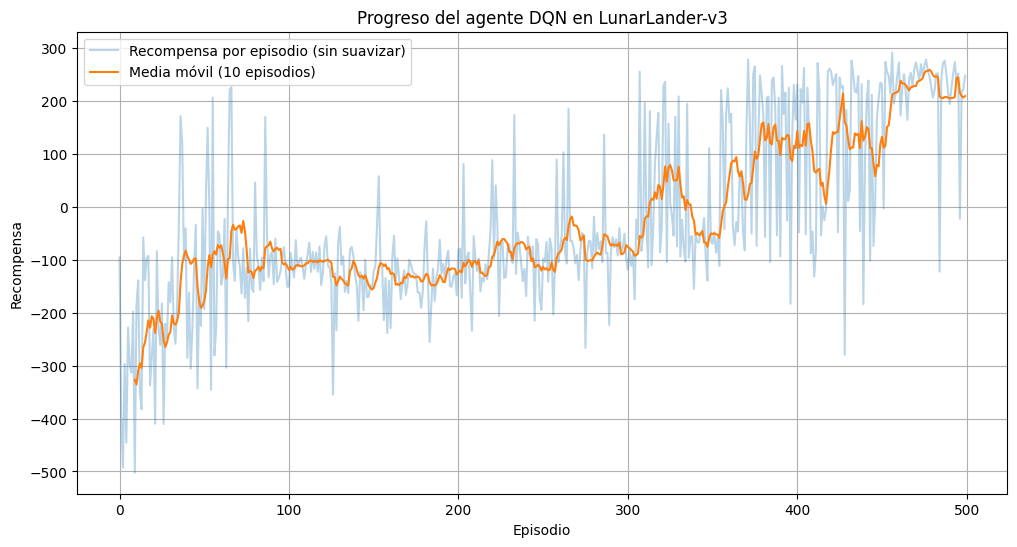

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convertimos la lista de recompensas a un array de NumPy para facilitar el cálculo
rewards_array = np.array(all_rewards)

# Definimos el tamaño de la ventana para la media móvil
window_size = 10

# Calculamos la media móvil con convolución
moving_avg = np.convolve(rewards_array, np.ones(window_size)/window_size, mode='valid')

# Graficamos
plt.figure(figsize=(12, 6))
plt.plot(all_rewards, alpha=0.3, label='Recompensa por episodio (sin suavizar)')
plt.plot(range(window_size - 1, len(all_rewards)), moving_avg, label=f'Media móvil ({window_size} episodios)')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.title('Progreso del agente DQN en LunarLander-v3')
plt.legend()
plt.grid(True)
plt.show()

**¿Qué es una media móvil?**

Una media móvil es una técnica de suavizado que se utiliza para resaltar tendencias en datos ruidosos o con mucha variabilidad, como es el caso de las recompensas por episodio en entrenamiento con reinforcement learning.

**¿Cómo funciona?**

1. Toma un número fijo de elementos (por ejemplo, los últimos 10 episodios).

2. Calcula el promedio de esos elementos.

3. Se desplaza una posición y repite el proceso.

**Resultado: una nueva curva más suave que te permite ver si, en general, el agente está mejorando o no.**

##### Evaluate the agent

In [ ]:
import time
from IPython.display import clear_output, Image, display
import matplotlib.pyplot as plt

# Evaluamos el agente sin exploración
def evaluate_agent(episodes=5):
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        frames = []  # Para capturar cada frame del entorno si quieres animación

        while not done:
            # Convertimos el estado a tensor y elegimos la mejor acción sin exploración
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = policy_net(state_tensor)
            action = int(torch.argmax(q_values).item())

            # Ejecutamos la acción en el entorno
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            # Renderizamos y mostramos (puede variar según entorno)
            frame = env.render()
            frames.append(frame)

            state = next_state

        print(f"Evaluación episodio {ep+1}: recompensa = {total_reward:.2f}")
        time.sleep(1)

    env.close()

In [ ]:
evaluate_agent()

Evaluación episodio 1: recompensa = 283.56
Evaluación episodio 2: recompensa = 253.57
Evaluación episodio 3: recompensa = 241.42
Evaluación episodio 4: recompensa = -267.63
Evaluación episodio 5: recompensa = 29.42


In [ ]:
# Visualización del agente entrenado
env = gym.make("LunarLander-v3", render_mode="rgb_array")
state, _ = env.reset()
frames = []
done = False
while not done:
    frames.append(env.render())
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        action = policy_net(state_tensor).argmax().item()
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
env.close()

# Crear animación
fig, ax = plt.subplots()
ax.axis('off')
im = ax.imshow(frames[0])

def animate(i):
    im.set_array(frames[i])
    return [im]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
plt.close(fig)
HTML(ani.to_jshtml())